# Вариант 1
Цель: Контроль дисперсии весов.

Разработайте архитектуру, которая будет за 5 слоев приводить тензор к размерности (1, 512, 1, 1).

Условие: дисперсия весов третьего слоя должна быть в два раза больше, чем у второго и четвертого.

Эксперимент: Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

In [8]:
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

In [9]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        #Слой 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1) # (1, 64, 16, 16)
        
        #Слой 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # (1, 128, 8, 8)
        
        #Слой 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1) # (1, 256, 4, 4)
        
        #Слой 4
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1) # (1, 512, 2, 2)
        
        #Слой 5
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=2, padding=0) # (1, 512, 1, 1)
        
        self.relu = nn.ReLU()

        self.GAP = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        # (1, 3, 32, 32)
        x = self.relu(self.conv1(x))  # (1, 64, 16, 16)
        x = self.relu(self.conv2(x))  # (1, 128, 8, 8)
        x = self.relu(self.conv3(x))  # (1, 256, 4, 4)
        x = self.relu(self.conv4(x))  # (1, 512, 2, 2)
        x = self.relu(self.conv5(x))  # (1, 512, 1, 1)
        x = self.GAP(x)
        
        return x

# Проверка
model = ConvNet()
input_tensor = torch.randn(1, 3, 32, 32)
output = model(input_tensor)
print(f"Начальная размерность тензора: {input_tensor.shape}")
print(f"Размерность выходного тензора: {output.shape}")

Начальная размерность тензора: torch.Size([1, 3, 32, 32])
Размерность выходного тензора: torch.Size([1, 512, 1, 1])


In [10]:
# Инициализация весов

def initialize_weights(model, weighedconv3=False, base_std=0.1):
    """Простая инициализация с контролем дисперсии"""
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            if 'conv3' in name and weighedconv3:
                # Дисперсия в 2 раза больше
                init.normal_(module.weight, 0.0, base_std * (2**0.5)) # домножаем на корень из двух
            else:
                init.normal_(module.weight, 0.0, base_std)
            
            if module.bias is not None:
                init.constant_(module.bias, 0)

# Использование
model = ConvNet()
initialize_weights(model, weighedconv3=True)

input_tensor = torch.randn(1, 3, 32, 32)
output = model(input_tensor)
print(f"Начальная размерность тензора: {input_tensor.shape}")
print(f"Размерность выходного тензора: {output.shape}")
print()

# Проверка дисперсий
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        var = module.weight.var().item()
        print(f"{name}: дисперсия = {var:.6f}")

Начальная размерность тензора: torch.Size([1, 3, 32, 32])
Размерность выходного тензора: torch.Size([1, 512, 1, 1])

conv1: дисперсия = 0.009895
conv2: дисперсия = 0.009990
conv3: дисперсия = 0.019969
conv4: дисперсия = 0.010005
conv5: дисперсия = 0.010006


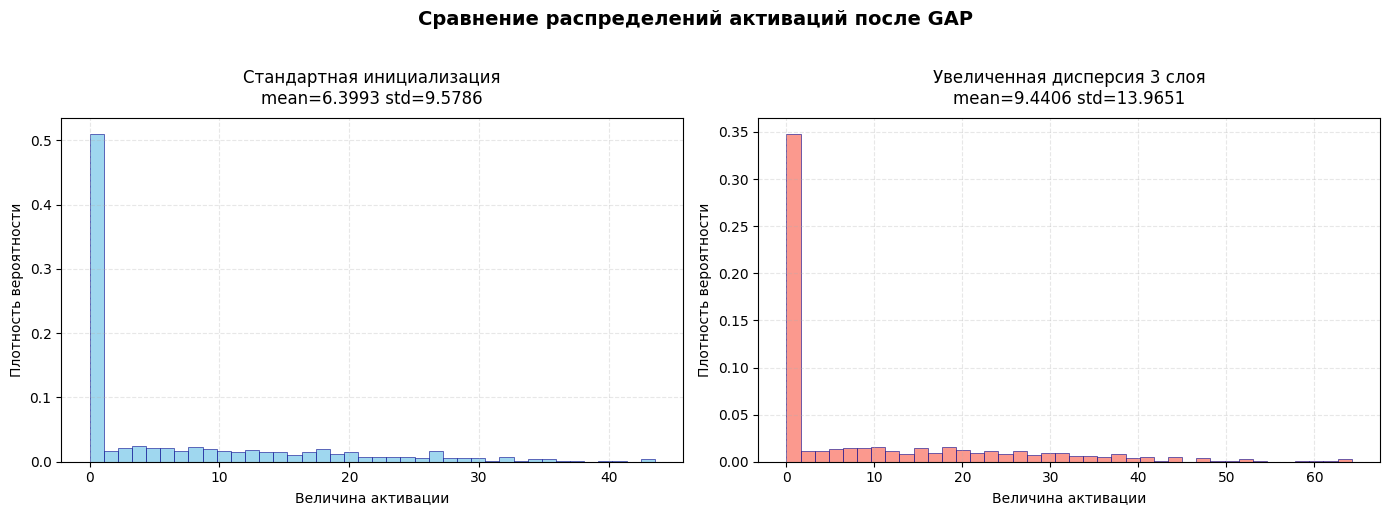

In [11]:
def plot_activation_distributions(models, model_names=['Стандартная инициализация', 'Увеличенная дисперсия 3 слоя'], colors=['skyblue', 'salmon']):
    """Визуализация распределений активаций после GAP"""
    
    x = torch.randn(1, 3, 32, 32)
    activations = []
    with torch.no_grad():
        for model in models:
            output = model(x)
            activations.append(output)
    
    # Создаем график
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for i, activation in enumerate(activations):
        values = activation.numpy().flatten()
                # Строим гистограмму
        axes[i].hist(values, bins=40, color=colors[i], alpha=0.8, 
                    edgecolor='darkblue', linewidth=0.5, density=True)
        
        axes[i].set_title(f'{model_names[i]}\nmean={values.mean():.4f} std={values.std():.4f}', 
                         fontsize=12, pad=10)
        axes[i].set_xlabel('Величина активации', fontsize=10)
        axes[i].set_ylabel('Плотность вероятности', fontsize=10)
        axes[i].grid(True, alpha=0.3, linestyle='--')
        
    
    fig.suptitle('Сравнение распределений активаций после GAP', 
                fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()

model_std = ConvNet()
model_enh = ConvNet()

initialize_weights(model_std, weighedconv3=False)  # Стандартная
initialize_weights(model_enh, weighedconv3=True)   # С увеличенной дисперсией

plot_activation_distributions([model_std, model_enh])


Можно заметить, что в модели с увеличенной дисперсией 3 слоя активации принимают большие значения, чем при равной дисперсии слоёв.

# Вариант 2

Цель: Контроль пространственных размерностей через свертки и пулинг.

Спроектируйте сеть для выхода (64, 16, 16) за не более 3 слоев свертки.

Условие: Используйте как минимум один слой с padding=0, чтобы часть пространственной информации была потеряна. Можно менять в таких условиях kernel_size и stride.

Эксперимент: Сравните выход с использованием padding=0 и padding=1, оцените разницу в размерности и среднее значение активаций.

In [49]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class ConvNet2(nn.Module):
    def __init__(self, padding_zero=False):
        super().__init__()
        
        # Слой 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # (32, 16, 16)
        
        if padding_zero:
            # Второй слой с padding=0 (теряем информацию)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0)  # (64, 16, 16), сделали kernel_size=1
            # Третий слой
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # (64, 16, 16) 
        else:
            # Все слои с padding=1 (сохраняем информацию)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # (64, 16, 16)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # (64, 16, 16)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):

        x = self.relu(self.conv1(x))  
        x = self.relu(self.conv2(x))  
        x = self.relu(self.conv3(x))  
        
        return x


Модель 1 (с padding=0):
Размерность выхода: torch.Size([1, 64, 16, 16])
Mean activation: 0.0376

Модель 2 (с padding=1):
Размерность выхода: torch.Size([1, 64, 16, 16])
Mean activation: 0.0306


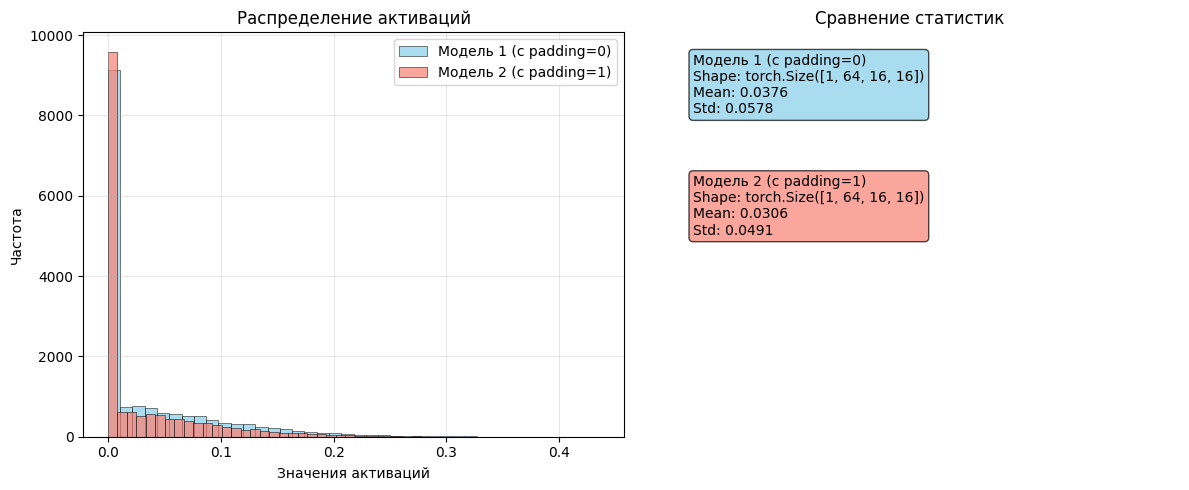

In [ ]:
# Эксперимент
def run_experiment():
    input_tensor = torch.randn(1, 3, 32, 32)
    
    models = {
        "Модель 1 (с padding=0)": ConvNet2(padding_zero=True),
        "Модель 2 (с padding=1)": ConvNet2(padding_zero=False)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{name}:")
        
        with torch.no_grad():
            output = model(input_tensor)
            
        results[name] = {
            'output_shape': output.shape,
            'mean_activation': output.mean().item(),
            'std_activation': output.std().item(),
            'min_activation': output.min().item(),
            'max_activation': output.max().item()
        }
        
        print(f"Размерность выхода: {output.shape}")
        print(f"Mean activation: {output.mean().item():.4f}")
    
    # Визуализация результатов
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    colors = ['skyblue', 'salmon']
    
    for i, (name, result) in enumerate(results.items()):
        # Гистограмма активаций
        with torch.no_grad():
            output = models[name](input_tensor)
            activations = output.numpy().flatten()
        
        axes[0].hist(activations, bins=40, alpha=0.7, color=colors[i], 
                    label=name, edgecolor='black', linewidth=0.5)
        
        # Статистика
        stats_text = f"{name}\nShape: {result['output_shape']}\nMean: {result['mean_activation']:.4f}\nStd: {result['std_activation']:.4f}"
        axes[1].text(0.1, 0.8 - i*0.3, stats_text, transform=axes[1].transAxes, 
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[i], alpha=0.7))
    
    axes[0].set_xlabel('Значения активаций')
    axes[0].set_ylabel('Частота')
    axes[0].set_title('Распределение активаций')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Сравнение статистик')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment()

Несмотря на использование padding=0 в одном из слоев модели 1, что привело к потере пространственной информации, был достигнут одинаковый конечный размер (64, 16, 16) за счет уменьшения ядра kernel_size=1 на втором слое. 

У модели, все слои которой имеют padding=1, среднее значение активаций больше, чем у модели, содержащей слой с padding=0, однако средние значения активаций довольно близки.